# Fourtress Demo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns

from ast import literal_eval
from itertools import chain,cycle
from IPython.display import display, display_html, Image

import io
import seaborn as sns

#model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

#algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#metrics
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Some useful functions...

In [2]:
def get_missing_values(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
    display(missing_df.sort_values('filling factor (%)').reset_index(drop = True))

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Data exploration

#### *Hoe ziet de data eruit?*

In [3]:
fl = pd.read_csv('../data/flights.csv') # we laden de data in een Pandas Dataframe object

In [4]:
fl.shape

(523275, 28)

In [5]:
fl.head()

,actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,...,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions
0,NaN,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:02:07,P,NaN,NaN,NaN
1,NaN,PHPXY,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:00,NaN,NaN,NaN,NaN
2,NaN,NaN,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:29,P,NaN,NaN,NaN
3,2018-01-01T03:22:00.000+01:00,PHPXB,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['DEP'],['AMS'],2018-01-01,03:30:00,NaN,NaN,NaN,NaN
4,2018-01-01T05:58:22.000+01:00,PHHSJ,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,...,TRA,NaN,['DEP'],['SPC'],2018-01-01,06:00:00,J,1.0,NaN,NaN


#### *Welke variabelen zitten er in de data?*

In [6]:
fl.columns.values

array(['actualOffBlockTime', 'aircraftRegistration',
       'aircraftType.iatamain', 'aircraftType.iatasub', 'airlineCode',
       'baggageClaim', 'estimatedLandingTime', 'expectedTimeBoarding',
       'expectedTimeGateClosing', 'expectedTimeGateOpen',
       'expectedTimeOnBelt', 'flightDirection', 'flightName',
       'flightNumber', 'gate', 'id', 'mainFlight', 'prefixIATA',
       'prefixICAO', 'publicEstimatedOffBlockTime',
       'publicFlightState.flightStates', 'route.destinations',
       'scheduleDate', 'scheduleTime', 'serviceType', 'terminal',
       'transferPositions', 'transferPositions.transferPositions'],
      dtype=object)

#### *Missende data zijn onhandig, waar zitten de meeste missende data?*

In [7]:
get_missing_values(fl)

,variable,missing values,filling factor (%)
0,transferPositions,523275,0.000000
1,expectedTimeOnBelt,523275,0.000000
2,baggageClaim,523275,0.000000
3,estimatedLandingTime,523275,0.000000
4,transferPositions.transferPositions,495956,5.220773
5,publicEstimatedOffBlockTime,442560,15.424968
6,expectedTimeGateOpen,109097,79.151116
7,expectedTimeBoarding,96356,81.585973
8,expectedTimeGateClosing,96356,81.585973
9,gate,39728,92.407816


Ik heb zelf al een selectie gemaakt van variabelen die ikzelf minder nuttig acht, aangevuld met de variabelen met veel NaN waarden. Deze sla ik op in een lijst om later weer te gebruiken. 

In [8]:
to_drop = ['aircraftRegistration','baggageClaim','estimatedLandingTime','expectedTimeOnBelt',
           'mainFlight','flightName','flightNumber','airlineCode','prefixIATA','publicEstimatedOffBlockTime',
           'transferPositions','transferPositions.transferPositions','route.destinations',
           'publicFlightState.flightStates']

In [9]:
fl['route.destinations'].value_counts()

['CDG']           17089
['CPH']           14355
['LHR']           14208
['MAN']           12269
['MAD']           12183
                  ...  
['FRA', 'SVO']        1
['TPS', 'AHO']        1
['HHN', 'GYD']        1
['JED', 'RUH']        1
['ANG']               1
Name: route.destinations, Length: 1017, dtype: int64

In [ ]:
fl[fl['route.destinations'].str.len()>14]['route.destinations']

In [10]:
fl['n_dest'] = fl['route.destinations'].map(eval).map(len)
fl['final_destination'] = fl['route.destinations'].apply(eval)
fl['final_destination'] = fl['final_destination'].map(lambda x: x[-1])
fl.drop(columns=to_drop, inplace=True) # verwijdert columns die ik niet meer nodig heb
fl.dropna(how='any', inplace=True) # verwijdert alle rijen met tenminste 1 NaN waarde

Hoe staat het nu met de missende waarden?

In [11]:
get_missing_values(fl)

,variable,missing values,filling factor (%)
0,actualOffBlockTime,0,100.0
1,aircraftType.iatamain,0,100.0
2,aircraftType.iatasub,0,100.0
3,expectedTimeBoarding,0,100.0
4,expectedTimeGateClosing,0,100.0
5,expectedTimeGateOpen,0,100.0
6,flightDirection,0,100.0
7,gate,0,100.0
8,id,0,100.0
9,prefixICAO,0,100.0


In [12]:
fl.shape

(388187, 16)

In [13]:
fl.head()

,actualOffBlockTime,aircraftType.iatamain,aircraftType.iatasub,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,flightDirection,gate,id,prefixICAO,scheduleDate,scheduleTime,serviceType,terminal,n_dest,final_destination
19,2018-01-01T06:48:51.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,D,B28,123414479666450001,KLM,2018-01-01,06:50:00,J,1.0,1,DUS
20,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,D,B32,123414478610028441,CSN,2018-01-01,06:50:00,J,1.0,1,BRU
21,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,D,B32,123414479922149375,CXA,2018-01-01,06:50:00,J,1.0,1,BRU
22,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,D,B32,123414479929232511,MAS,2018-01-01,06:50:00,J,1.0,1,BRU
24,2018-01-01T06:57:39.000+01:00,73H,73H,2018-01-01T06:20:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T05:50:00.000+01:00,D,C12,123414479071263641,GIA,2018-01-01,06:50:00,J,1.0,1,FCO


#### *Hoe gevarieerd zijn de variabelen?*

In [14]:
fl.nunique().sort_values()

flightDirection                 1
serviceType                     2
n_dest                          2
terminal                        3
aircraftType.iatamain          30
aircraftType.iatasub           42
prefixICAO                     73
gate                          137
scheduleTime                  192
scheduleDate                  193
final_destination             200
expectedTimeGateClosing     32141
expectedTimeGateOpen        32603
expectedTimeBoarding        32772
actualOffBlockTime          75554
id                         380662
dtype: int64

`flightDirection`,`serviceType` hebben erg weinig verschillende waarden (niet handig vor training), het aantal verschillende waarden voor `gate` is erg hoog. Dit vraagt om wat nader onderzoek. 

In [15]:
display(fl['serviceType'].value_counts())
display(fl['flightDirection'].value_counts())
display(fl['gate'].value_counts())

J    388179
C         8
Name: serviceType, dtype: int64

D    388187
Name: flightDirection, dtype: int64

D06    47247
B18    12483
B02    11890
B16     8715
B04     8244
       ...  
C24      102
G16       84
G13       79
G14       64
G11       36
Name: gate, Length: 137, dtype: int64

`flightDirection` heeft maar 8 waarden die niet J zijn maar C en `serviceType` heeft maar een categorie('D' of 'Departing flights'). Beide scenario's kunnen dus beter weggelaten worden. Voor `gate` pak ik alleen de eerste letter in plaats van letter en gate nummer. Dit om de hoeveelheid variabelen en waarden voor training te minimaliseren in de hoop een beter model te krijgen. 

In [16]:
fl = fl.query("serviceType=='J'") # Delete C since only 8 cases in dataset
fl.drop(columns=['serviceType','flightDirection'],inplace=True) # Delete constants
fl['gate'] = fl['gate'].str[0] #Too many options, therefore use only the first character for gate variable

In [17]:
fl.gate.value_counts()

D    158314
B    118534
C     72462
E     22185
F     13169
G      3515
Name: gate, dtype: int64

In [18]:
fl.head()

,actualOffBlockTime,aircraftType.iatamain,aircraftType.iatasub,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,gate,id,prefixICAO,scheduleDate,scheduleTime,terminal,n_dest,final_destination
19,2018-01-01T06:48:51.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479666450001,KLM,2018-01-01,06:50:00,1.0,1,DUS
20,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414478610028441,CSN,2018-01-01,06:50:00,1.0,1,BRU
21,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479922149375,CXA,2018-01-01,06:50:00,1.0,1,BRU
22,2018-01-01T06:51:30.000+01:00,EMJ,E90,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479929232511,MAS,2018-01-01,06:50:00,1.0,1,BRU
24,2018-01-01T06:57:39.000+01:00,73H,73H,2018-01-01T06:20:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T05:50:00.000+01:00,C,123414479071263641,GIA,2018-01-01,06:50:00,1.0,1,FCO


Deze waarden zien er stukken beter uit en hebben zo waarschijnlijk meer voorspellende waarde. 

#### *Wat te doen met de vliegtuig type nummers?

In [19]:
fl['aircraft_type_option1'] = fl['aircraftType.iatamain'] 
fl['aircraft_type_option1'].nunique()

30

In [20]:
fl['aircraft_type_option2'] = fl['aircraftType.iatamain'] + '-' + fl['aircraftType.iatasub']
fl['aircraft_type_option2'].nunique()

42

In [21]:
fl['aircraft_type'] = fl['aircraftType.iatamain'] 

In [22]:
fl.drop(columns=['aircraftType.iatamain','aircraftType.iatasub','aircraft_type_option1','aircraft_type_option2'],inplace=True)

# Determine delay

In [23]:
delay_threshold = 10 #after how many minutes the flight is labeled delayed, assumption for rest of the notebook

fl['scheduleDatetime'] = pd.to_datetime(fl['scheduleDate'] + ' ' 
                                        + fl['scheduleTime']).dt.tz_localize('Europe/Amsterdam')
fl['actualOffBlockTime'] = pd.to_datetime(fl['actualOffBlockTime'], utc=True).dt.tz_convert('Europe/Amsterdam')

fl['delay'] = fl['actualOffBlockTime'].sub(fl['scheduleDatetime']).dt.total_seconds().div(60) #delay in minutes
fl['delayed'] = np.where(fl['delay']>=delay_threshold,1,0)

In [24]:
fl.head()

,actualOffBlockTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,gate,id,prefixICAO,scheduleDate,scheduleTime,terminal,n_dest,final_destination,aircraft_type,scheduleDatetime,delay,delayed
19,2018-01-01 06:48:51+01:00,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479666450001,KLM,2018-01-01,06:50:00,1.0,1,DUS,EMJ,2018-01-01 06:50:00+01:00,-1.15,0
20,2018-01-01 06:51:30+01:00,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414478610028441,CSN,2018-01-01,06:50:00,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
21,2018-01-01 06:51:30+01:00,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479922149375,CXA,2018-01-01,06:50:00,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
22,2018-01-01 06:51:30+01:00,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479929232511,MAS,2018-01-01,06:50:00,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
24,2018-01-01 06:57:39+01:00,2018-01-01T06:20:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T05:50:00.000+01:00,C,123414479071263641,GIA,2018-01-01,06:50:00,1.0,1,FCO,73H,2018-01-01 06:50:00+01:00,7.65,0


In [25]:
fl['delayed'].value_counts()

0    240777
1    147402
Name: delayed, dtype: int64

### Investigate delay, number of flights per carrier, delay per carrier

count    326649.000000
mean         15.455710
std          24.748113
min           0.016667
25%           3.883333
50%           8.666667
75%          17.883333
max        1443.866667
Name: delay, dtype: float64

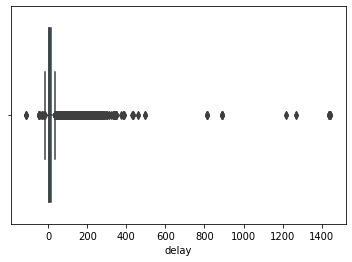

In [26]:
display(fl[fl['delay']>0]['delay'].describe())
fl['delay'].describe()
ax = sns.boxplot(x=fl['delay'])

count    383980.000000
mean         11.155018
std          15.392652
min        -114.000000
25%           1.750000
50%           6.433333
75%          15.016667
max          99.933333
Name: delay, dtype: float64

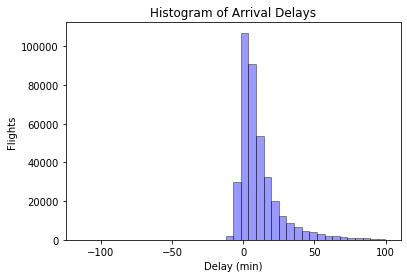

In [27]:
sns.distplot(fl[fl['delay']<100]['delay'], hist=True, kde=False, 
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')


fl[fl['delay']<100]['delay'].describe()

#### **Valt er iets te zeggen over de maatschappijen m.b.t. vertragingen?**

<AxesSubplot:ylabel='n_flights'>

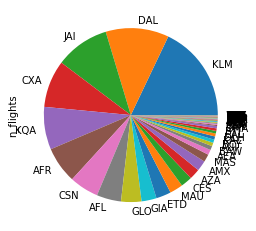

In [28]:
n_flights = fl['prefixICAO'].value_counts().rename('n_flights')
n_flights.plot.pie()

In [29]:
avg_delay = fl.groupby('prefixICAO')['delay'].mean().rename('avg_delay')
n_delays = fl.groupby('prefixICAO')['delayed'].sum().rename('n_delays')
carrier_comparison = pd.merge(pd.merge(n_flights, avg_delay, left_index=True, right_index=True), n_delays, left_index=True, right_index=True)
carrier_comparison['average_n_delay'] = carrier_comparison['n_delays'] / carrier_comparison['n_flights']

#### **Hoe goed doen de maatschappijen het?**

In [30]:
display_side_by_side(carrier_comparison.sort_values('avg_delay', ascending=False).head(10),
                     carrier_comparison.sort_values('avg_delay', ascending=False).tail(10), titles=['Top 10 - Average Delay','Bottom 10  - Average Delay'])

,n_flights,avg_delay,n_delays,average_n_delay
VLG,10,170.318333,9,0.900000
IBE,10,170.318333,9,0.900000
SRK,5,133.743333,5,1.000000
TVS,1,102.350000,1,1.000000
TRA,18,85.615741,16,0.888889
DTA,87,68.741571,20,0.229885
EZY,1,48.800000,1,1.000000
TAP,113,42.348820,112,0.991150
MSR,197,39.087056,181,0.918782
RAM,220,37.802803,125,0.568182


In [31]:
display_side_by_side(carrier_comparison.sort_values('average_n_delay', ascending=False).head(10),
                     carrier_comparison.sort_values('average_n_delay', ascending=False).tail(10), titles=['Top 20 - Proportion Delayed','Bottom 20 - Proportion Delayed'])

,n_flights,avg_delay,n_delays,average_n_delay
TVS,1,102.350000,1,1.000000
EZY,1,48.800000,1,1.000000
TVF,1,25.783333,1,1.000000
AUA,1,19.300000,1,1.000000
TGZ,1,22.033333,1,1.000000
SRK,5,133.743333,5,1.000000
TAP,113,42.348820,112,0.991150
VIR,17,31.602941,16,0.941176
MSR,197,39.087056,181,0.918782
VLG,10,170.318333,9,0.900000


count     71.000000
mean      26.386215
std       32.571945
min       -4.000000
25%       12.593893
50%       15.487941
75%       22.741931
max      170.318333
Name: avg_delay, dtype: float64

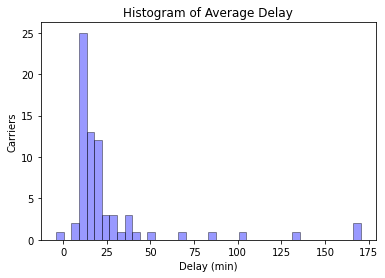

In [32]:
sns.distplot(carrier_comparison['avg_delay'], hist=True, kde=False, #dataframe sliced for readability
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Average Delay')
plt.xlabel('Delay (min)')
plt.ylabel('Carriers')
carrier_comparison['avg_delay'].describe()

In [ ]:
ax = sns.boxplot(x=carrier_comparison['avg_delay'])
carrier_comparison['avg_delay'].describe()

### Feature Engineering voor Training

In [33]:
fl.drop(columns=['scheduleTime','scheduleDate','actualOffBlockTime'],inplace=True)

In [34]:
fl.head()

,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,gate,id,prefixICAO,terminal,n_dest,final_destination,aircraft_type,scheduleDatetime,delay,delayed
19,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479666450001,KLM,1.0,1,DUS,EMJ,2018-01-01 06:50:00+01:00,-1.15,0
20,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414478610028441,CSN,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
21,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479922149375,CXA,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
22,2018-01-01T06:25:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T06:20:00.000+01:00,B,123414479929232511,MAS,1.0,1,BRU,EMJ,2018-01-01 06:50:00+01:00,1.50,0
24,2018-01-01T06:20:00.000+01:00,2018-01-01T06:35:00.000+01:00,2018-01-01T05:50:00.000+01:00,C,123414479071263641,GIA,1.0,1,FCO,73H,2018-01-01 06:50:00+01:00,7.65,0


In [35]:
fl['expectedTimeGateClosing'] = pd.to_datetime(fl['expectedTimeGateClosing'], utc=True).dt.tz_convert('Europe/Amsterdam')
fl['expectedTimeGateOpen'] = pd.to_datetime(fl['expectedTimeGateOpen'], utc=True).dt.tz_convert('Europe/Amsterdam')
fl['expectedTimeBoarding'] = pd.to_datetime(fl['expectedTimeBoarding'], utc=True).dt.tz_convert('Europe/Amsterdam')

In [36]:
fl['gate_open_time'] = fl['expectedTimeGateClosing'].sub(fl['expectedTimeGateOpen']).dt.total_seconds().div(60)
fl['gate_open_to_departure_time'] = fl['scheduleDatetime'].sub(fl['expectedTimeGateOpen']).dt.total_seconds().div(60)
fl['gate_closed_to_departure_time'] = fl['scheduleDatetime'].sub(fl['expectedTimeGateClosing']).dt.total_seconds().div(60)
fl['boarding_to_departure_time'] = fl['scheduleDatetime'].sub(fl['expectedTimeBoarding']).dt.total_seconds().div(60)

count    388179.000000
mean         51.360336
std          25.931638
min       -1350.000000
25%          30.000000
50%          60.000000
75%          60.000000
max         145.000000
Name: gate_open_to_departure_time, dtype: float64

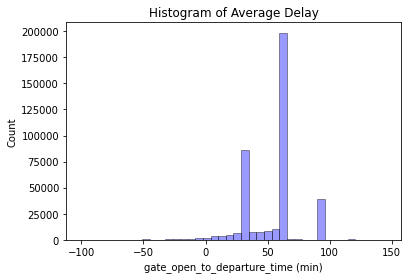

In [37]:
sns.distplot(fl[fl['gate_open_to_departure_time']>=-100]['gate_open_to_departure_time'], hist=True, kde=False, #dataframe sliced for readability
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Average Delay')
plt.xlabel('gate_open_to_departure_time (min)')
plt.ylabel('Count')

fl['gate_open_to_departure_time'].describe()

count    388179.000000
mean         40.524925
std          17.919415
min          15.000000
25%          15.000000
50%          45.000000
75%          45.000000
max         125.000000
Name: gate_open_time, dtype: float64

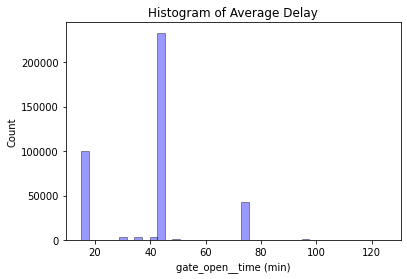

In [38]:
sns.distplot(fl[fl['gate_open_time']>=-100]['gate_open_time'], hist=True, kde=False, #dataframe sliced for readability
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Average Delay')
plt.xlabel('gate_open__time (min)')
plt.ylabel('Count')

fl['gate_open_time'].describe()

count    388179.000000
mean         10.835411
std          19.082844
min       -1425.000000
25%          15.000000
50%          15.000000
75%          15.000000
max          55.000000
Name: gate_closed_to_departure_time, dtype: float64

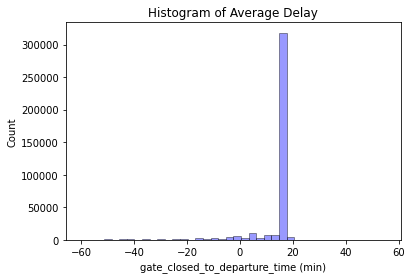

In [39]:
sns.distplot(fl[fl['gate_closed_to_departure_time']>=-60]['gate_closed_to_departure_time'], hist=True, kde=False, #dataframe sliced for readability
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Average Delay')
plt.xlabel('gate_closed_to_departure_time (min)')
plt.ylabel('Count')

fl['gate_closed_to_departure_time'].describe()

count    388179.000000
mean         26.740993
std          20.186825
min       -1395.000000
25%          25.000000
50%          30.000000
75%          30.000000
max          80.000000
Name: boarding_to_departure_time, dtype: float64

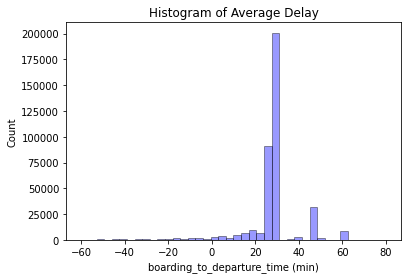

In [40]:
sns.distplot(fl[fl['boarding_to_departure_time']>=-60]['boarding_to_departure_time'], hist=True, kde=False, #dataframe sliced for readability
             bins=int(200/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Average Delay')
plt.xlabel('boarding_to_departure_time (min)')
plt.ylabel('Count')

fl['boarding_to_departure_time'].describe()

In [41]:
fl.drop(columns=['expectedTimeGateOpen','expectedTimeGateClosing',
                 'expectedTimeBoarding','gate_closed_to_departure_time','scheduleDatetime'],inplace=True)

In [42]:
fl.head()

,gate,id,prefixICAO,terminal,n_dest,final_destination,aircraft_type,delay,delayed,gate_open_time,gate_open_to_departure_time,boarding_to_departure_time
19,B,123414479666450001,KLM,1.0,1,DUS,EMJ,-1.15,0,15.0,30.0,25.0
20,B,123414478610028441,CSN,1.0,1,BRU,EMJ,1.50,0,15.0,30.0,25.0
21,B,123414479922149375,CXA,1.0,1,BRU,EMJ,1.50,0,15.0,30.0,25.0
22,B,123414479929232511,MAS,1.0,1,BRU,EMJ,1.50,0,15.0,30.0,25.0
24,C,123414479071263641,GIA,1.0,1,FCO,73H,7.65,0,45.0,60.0,30.0


In [ ]:
fl.columns

Duplicaten verwijderen, just in case

In [43]:
fl.drop_duplicates(inplace=True)

Hoe zijn de daadwerkelijke labels nu verdeeld in de data?

In [44]:
fl['delayed'].value_counts()

0    238607
1    142048
Name: delayed, dtype: int64

The labels are not perfectly balanced but good enough for early model training. 

## Modelling & Evaluation

![title](img/training2.png)

In [ ]:
# fl_sample = fl.sample(frac=0.25)
# fl_sample.shape

#### Determine X and y

In [46]:
X = fl.drop(columns=['delayed','delay','id'])
y = fl['delayed']

In [47]:
X

,gate,prefixICAO,terminal,n_dest,final_destination,aircraft_type,gate_open_time,gate_open_to_departure_time,boarding_to_departure_time
19,B,KLM,1.0,1,DUS,EMJ,15.0,30.0,25.0
20,B,CSN,1.0,1,BRU,EMJ,15.0,30.0,25.0
21,B,CXA,1.0,1,BRU,EMJ,15.0,30.0,25.0
22,B,MAS,1.0,1,BRU,EMJ,15.0,30.0,25.0
24,C,GIA,1.0,1,FCO,73H,45.0,60.0,30.0
...,...,...,...,...,...,...,...,...,...
502409,E,AFR,2.0,1,PEK,787,75.0,90.0,45.0
502410,F,KLM,2.0,1,XMN,787,75.0,90.0,45.0
502412,E,CSN,2.0,1,PEK,787,75.0,90.0,45.0
502413,E,CXA,2.0,1,PEK,787,75.0,90.0,45.0


In [48]:
y.unique()

array([0, 1])

In [49]:
X.nunique()

gate                             6
prefixICAO                      71
terminal                         3
n_dest                           2
final_destination              196
aircraft_type                   30
gate_open_time                  11
gate_open_to_departure_time    208
boarding_to_departure_time     199
dtype: int64

#### **Apply some simple preprocessing**

In [50]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

column_trans = make_column_transformer(
    (OneHotEncoder(), ['gate','prefixICAO', 'terminal', 'aircraft_type','final_destination']),
    remainder='drop')

![title](img/onehot.png)

In [51]:
num_vars = ['gate_open_time', 'gate_open_to_departure_time','boarding_to_departure_time','n_dest']
X_cat = column_trans.fit_transform(X)
col_names = column_trans.get_feature_names() + num_vars #extract column names for feature importances
X_num = X[num_vars]

sc = StandardScaler()
sc.fit(X_num)

X_num = sc.transform(X_num)
X_cat = X_cat.toarray()
X = np.append(X_cat, X_num, 1)

**Hoe zit een willekeurige vector voor training er nu uit?**

In [52]:
X[42]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

#### Split into train and test set

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([214746, 127843]))
(array([0, 1]), array([23861, 14205]))


### Decision Tree Classifier (Baseline)

In [54]:
dt = DecisionTreeClassifier()

![title](img/crossval.jpg)

In [55]:
kfold = KFold(n_splits=3)
scores_dt = cross_val_score(dt, X_train, y_train, cv=kfold,scoring='accuracy',n_jobs=-1)
print(scores_dt)
scores_dt.mean()

[0.75283939 0.7499387  0.75028898]


0.7510223567685045

AUC: 0.7632482071122317
Accuracy: 0.7536121473230705
Precision: 0.8137025481019241
Recall: 0.4406195001759944


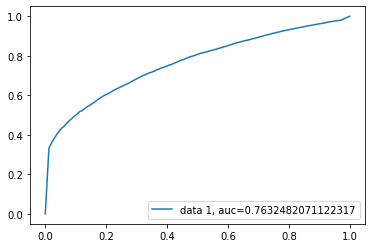

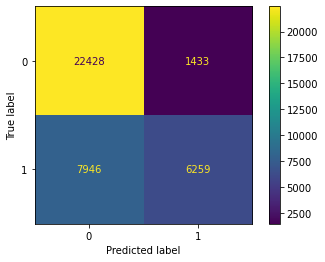

In [56]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC:",auc)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
metrics.plot_confusion_matrix(dt, X_test, y_test)

In [ ]:
imps = pd.DataFrame(columns=['Feature','Importance'])
imps['Feature'],imps['Importance'] = col_names, dt.feature_importances_
imps = imps.sort_values(by=['Importance'], ascending=False)
imps.head(20)

Boarding to departure time quite important here, perhaps overfitting on this variable. 

### Logistic Regression

In [ ]:
kfold = KFold(n_splits=3)
lr = LogisticRegression(max_iter=200)
scores_dt = cross_val_score(lr, X_train, y_train, cv=kfold,scoring='accuracy',n_jobs=-1)
print(scores_dt)
scores_dt.mean()

In [ ]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC:",auc)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
metrics.plot_confusion_matrix(lr, X_test, y_test)